In [1]:
import levinpower
import numpy as np
import time

Let us define an integral of the type
$$ I(y) = \int j_{\ell_1}(xk_1)j_{\ell_2}(xk_2)j_{\ell_3}(xk_3) f(x) \mathrm{d}x\,, $$
which we integrante from $x=10^{-5}$ to $100$. For the function we assume $f(x) = (x^3 - x^2 + x)x$. Refer to the example in ```test_levin_single.ipynb``` for more details on the individual steps in this tutorial.

In [2]:
x = np.geomspace(1e-5,100,100) #define support
f_of_x = (x**3 -x**2 +x)*x #define f(x) 

# define integral type for Levin, 0 correpsonds to single spherical Bessel function 
# 0: single spherical Bessel function
# 1: single cylindrical Bessel function
# 2: double spherical Bessel function
# 3: double cylindrical Bessel function
# 4: triple spherical Bessel function
# 5: triple cylindrical Bessel function
integral_type = 4 
N_thread = 1 # Number of threads used for hyperthreading
logx = True # Tells the code to create a logarithmic spline in x for f(x)
logy = True # Tells the code to create a logarithmic spline in y for y = f(x)
lp = levinpower.levinpower(integral_type, x, f_of_x[:,None], logx, logy, N_thread) #Constructor of the class, note we are passing f_of_x[:,None]
n_sub = 8 #number of collocation points in each bisection
n_bisec_max = 16 #maximum number of bisections used
rel_acc = 1e-6 #relative accuracy target
boost_bessel = False #should the bessel functions be calculated with boost instead of GSL, higher accuracy at high Bessel orders
verbose = False #should the code talk to you?
lp.set_levin(n_sub, n_bisec_max, rel_acc, boost_bessel, verbose)

In [3]:
N = 1000
k = np.geomspace(1e-2,1000,N)
n_order_1 = 5
n_order_2 = 10
n_order_3 = 15
ell_1 = (n_order_1*np.ones_like(k)).astype(int)
ell_2 = (n_order_2*np.ones_like(k)).astype(int)
ell_3 = (n_order_3*np.ones_like(k)).astype(int)

t0 = time.time()
result_levin = np.array(lp.levin_integrate_bessel_triple(x[0]*np.ones_like(k),x[-1]*np.ones_like(k),k,k,k,ell_1,ell_2,ell_3, False))
print("Levin took", time.time() -t0, "s")

Levin took 2.507460832595825 s


In [4]:
t0 = time.time()
result_levin_rerun = np.array(lp.levin_integrate_bessel_triple(x[0]*np.ones_like(k),x[-1]*np.ones_like(k),k,k,k,ell_1,ell_2,ell_3, False))
print("Levin took", time.time() -t0, "s")


Levin took 1.2180087566375732 s


In [5]:
t0 = time.time()
result_levin_rererun = np.array(lp.levin_integrate_bessel_triple(x[0]*np.ones_like(k),x[-1]*np.ones_like(k),k,k,k,ell_1,ell_2,ell_3, False))
print("Levin took", time.time() -t0, "s")


Levin took 0.056413888931274414 s


Trapeziodal took 2.934170961380005 s


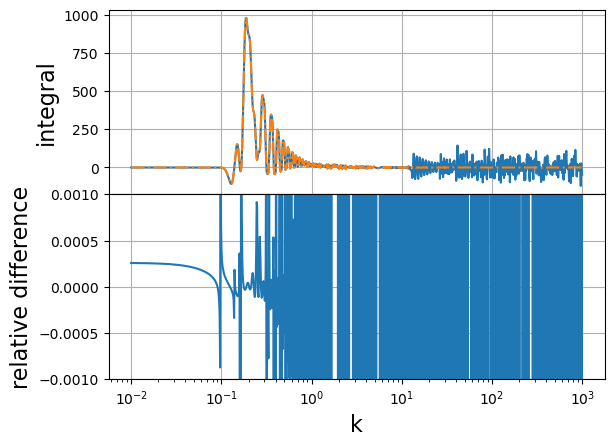

In [6]:
from scipy.special import spherical_jn
import matplotlib.pyplot as plt

trapz_result = np.zeros_like(result_levin)

N_trapz = int(1e4)
trapz_x = np.geomspace(1e-5,100,N_trapz)
trapz_of_x = ((trapz_x**3 -trapz_x**2 +trapz_x)*trapz_x)

t0 = time.time()
for k_i, k_val in enumerate(k):
    integrand = trapz_of_x* (spherical_jn(n_order_1,k_val*trapz_x)*spherical_jn(n_order_2,k_val*trapz_x)*spherical_jn(n_order_3,k_val*trapz_x))
    trapz_result[k_i, :] = np.trapz(integrand, trapz_x, axis = 0)
print("Trapeziodal took", time.time() -t0, "s")

fig, ax = plt.subplots(2)
ax[0].semilogx(k,trapz_result[:,0]*k**3)
ax[0].semilogx(k,result_levin_rererun[:,0]*k**3, ls = "-.")
ax[0].set_ylabel("integral", fontsize = 16)
ax[0].grid(axis = "both")
#ax[0].set_xticks([])

ax[1].semilogx(k, (trapz_result[:,0] - result_levin_rererun[:,0])/result_levin_rererun[:,0])
ax[1].set_xlabel("k", fontsize = 16)
ax[1].set_ylabel("relative difference", fontsize = 16)
ax[1].set_ylim(-1e-3,1e-3)
ax[1].grid()
plt.subplots_adjust(wspace=0, hspace=0)


Levin took 0.04667496681213379 s
Trapeziodal took 2.973667860031128 s


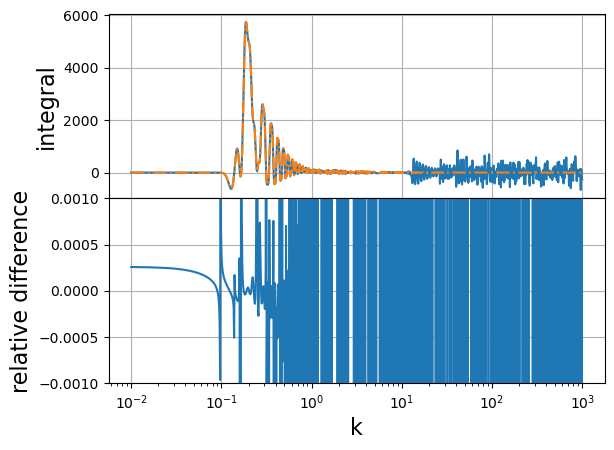

In [7]:
x = np.geomspace(1e-5,100,100)
y = (1.5*x**3.3 -0.69*x**2.5 +x**1.5)*x
lp.update_integrand(x,y[:, None], True, True)

t0 = time.time()
result_levin_rererun = np.array(lp.levin_integrate_bessel_triple(x[0]*np.ones_like(k),x[-1]*np.ones_like(k),k,k,k,ell_1,ell_2,ell_3, False))


print("Levin took", time.time() -t0, "s")

trapz_result = np.zeros_like(result_levin_rererun)

t0 = time.time()

N_trapz = int(1e4)
trapz_x = np.geomspace(1e-5,100,N_trapz)
trapz_of_x = ((1.5*trapz_x**3.3 -0.69*trapz_x**2.5 + trapz_x**1.5)*trapz_x)

for k_i, k_val in enumerate(k):
    integrand = trapz_of_x* (spherical_jn(n_order_1,k_val*trapz_x)*spherical_jn(n_order_2,k_val*trapz_x)*spherical_jn(n_order_3,k_val*trapz_x))
    trapz_result[k_i, :] = np.trapz(integrand, trapz_x, axis = 0)
print("Trapeziodal took", (time.time() -t0), "s")

fig, ax = plt.subplots(2)
ax[0].semilogx(k,trapz_result[:,0]*k**3)
ax[0].semilogx(k,result_levin_rererun[:,0]*k**3, ls = "-.")
ax[0].set_ylabel("integral", fontsize = 16)
ax[0].grid(axis = "both")
#ax[0].set_xticks([])

ax[1].semilogx(k, (trapz_result[:,0] - result_levin_rererun[:,0])/result_levin_rererun[:,0])
ax[1].set_xlabel("k", fontsize = 16)
ax[1].set_ylabel("relative difference", fontsize = 16)
ax[1].set_ylim(-1e-3,1e-3)
ax[1].grid()
plt.subplots_adjust(wspace=0, hspace=0)

